# Практика

In [ ]:
import numpy as np

class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        self.W = np.random.randn(input_size, output_size)*0.01
        self.b = np.zeros(output_size)

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        self.X = X
        return X.dot(self.W)+self.b

    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        self.dLdW = self.X.T.dot(dLdy)
        self.dLdb = dLdy.sum(0)
        self.dLdx = dLdy.dot(self.W.T)
        return self.dLdx

    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - learning_rate*dLdw
        '''
        self.W = self.W - learning_rate * self.dLdW
        self.b = self.b - learning_rate * self.dLdb

class Sigmoid:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = 1./(1+np.exp(-X))
        return self.s

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return self.s*(1-self.s)*dLdy

    def step(self, learning_rate):
        pass

class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        pass

    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.p = np.exp(X)
        self.p /= self.p.sum(1, keepdims=True)
        self.y = np.zeros((X.shape[0], X.shape[1]))
        self.y[np.arange(X.shape[0]), y] = 1
        return -(np.log(self.p)*self.y).sum(1).mean(0)

    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        return (self.p - self.y) / self.y.shape[0]


class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self.modules = modules

    def forward(self, X):
        y = X
        for i in range(len(self.modules)):
            y = self.modules[i].forward(y)
        return y

    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        for i in range(len(self.modules))[::-1]:
            dLdy = self.modules[i].backward(dLdy)

    def step(self, learning_rate):
        for i in range(len(self.modules)):
            self.modules[i].step(learning_rate)


# Работа с MNIST

Воспользуемся написанной нейронной сетью для решения задачи распознавания рукописных цифр. Также мы исследуем, как влияет выбор нелинейности и предобработка данных на качество классификации.

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import torch.nn as nn
import torch
import numpy as np
import sys
from IPython.display import clear_output
%matplotlib inline

In [ ]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

In [ ]:
set_seed(42)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [ ]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

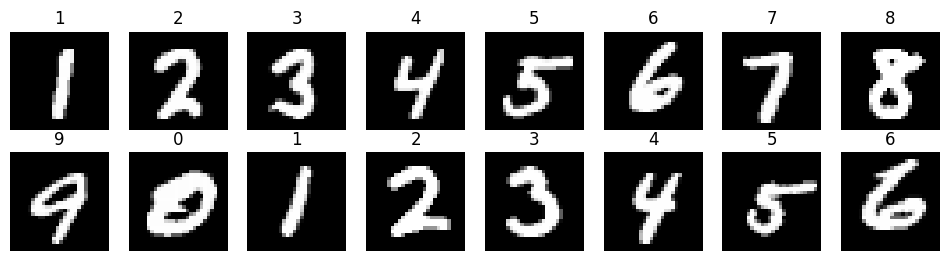

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(len(X)):
    plt.subplot(4, 8, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

## Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [ ]:
X[0].shape

(784,)

In [ ]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [ ]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.308/0.300	Accuracy: 0.918/0.919

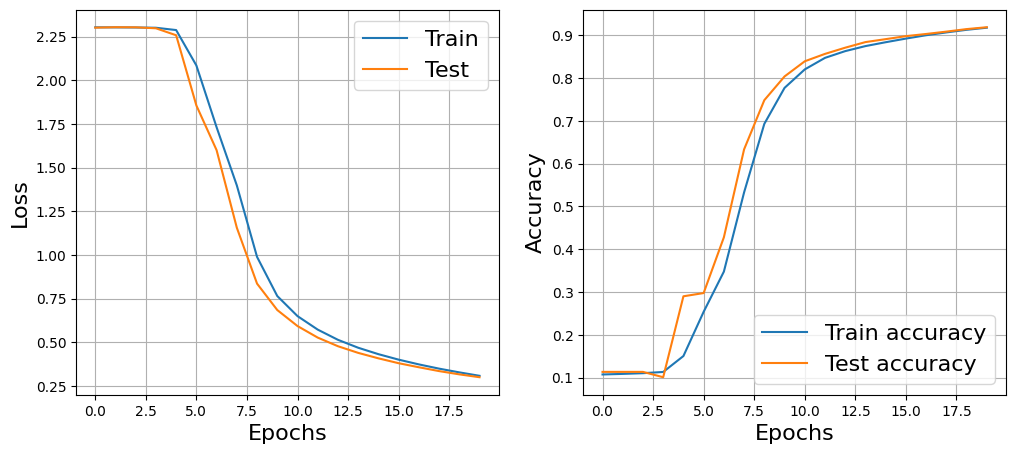

In [ ]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

## Часть 2: Нелинейности
Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [ ]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass


class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''

    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.035/0.082	Accuracy: 0.991/0.976

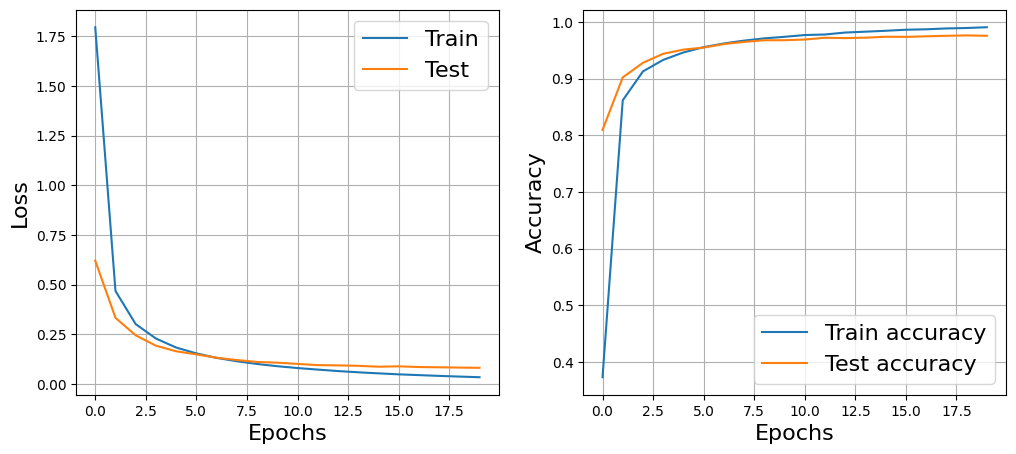

In [ ]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.044/0.078	Accuracy: 0.988/0.976

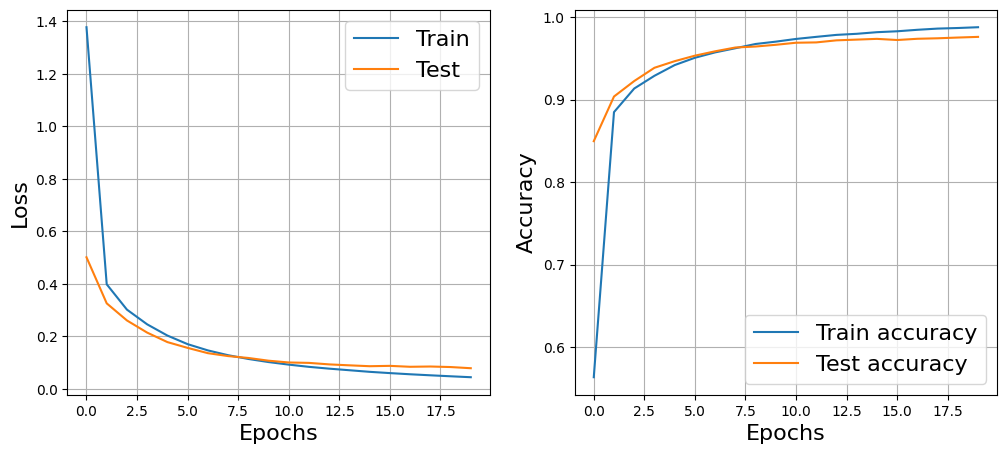

In [ ]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

Сравнение результатов

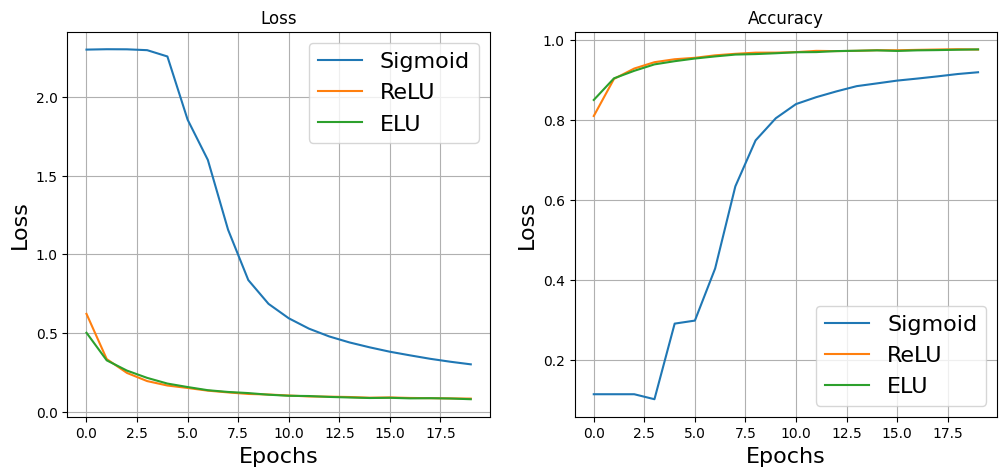

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

# Анализ ошибок

In [ ]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

/tmp/ipython-input-1661168083.py:17: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  wrong_X = np.row_stack(wrong_X)
/tmp/ipython-input-1661168083.py:18: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  correct_y = np.row_stack(correct_y)[:, 0]
/tmp/ipython-input-1661168083.py:19: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  predicted_y = np.row_stack(predicted_y)[:, 0]
/tmp/ipython-input-1661168083.py:20: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  logits = np.row_stack(logits)[:, 0]


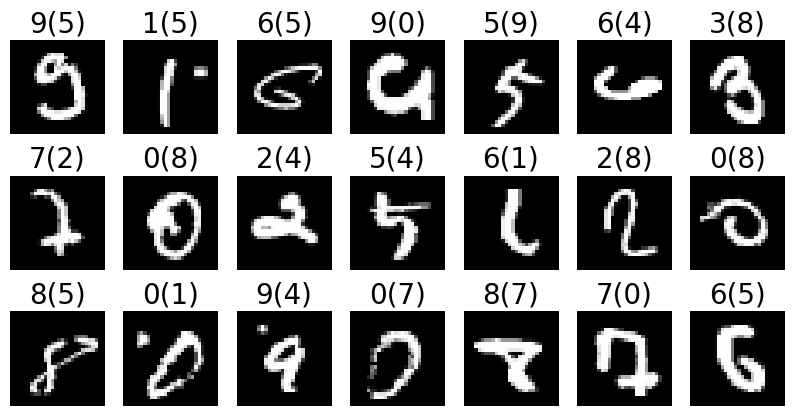

In [ ]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

# Задание 1 (1 балл): Реализовать Tanh
Нужно реализовать функцию активации Tanh по аналогии с примерами выше

In [ ]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        exp_squared = np.exp(-2 * X)
        '''
        tanh(x) = (e^x - e^-x) / (e^x + e^-x) =
        = (1 - e^-2x) / (1 + e^-2x) = (2 - 1 - e^-2x) / (1 + e^-2x) =
        = (2 - (1 + e^-2x)) / (1 + e^-2x) = (2 - (1 + e^-2x)) / (1 + e^-2x) =
        = 2 / (1 + e^-2x) - 1
        '''
        self.th = 2 / (1 + exp_squared) - 1
        return self.th

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dydX = 1 - self.th**2 #tanh(x)' = 1 - tanh(x)^2
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.032/0.077	Accuracy: 0.993/0.976

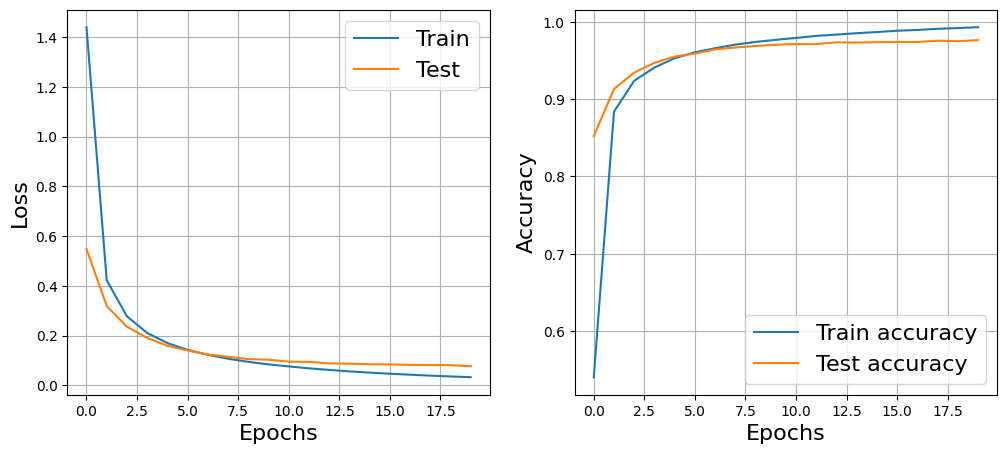

In [ ]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

# Задание 2 (4 балла): Аугментации
Необходимо реализовать следующие преобразования (пример можно найти в лекции, также допускается использовать готовые варианты, например "from skimage.transform import rotate")
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности? Какие можно сделать выводы? (Сравнивать подходы можно по аналогии с тем, как это было проделано выше)

### 1. Случайное вращение (-15, 15)

In [ ]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()

In [ ]:
transform_rot = transforms.Compose([
                       transforms.RandomRotation((-15, 15)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform_rot)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

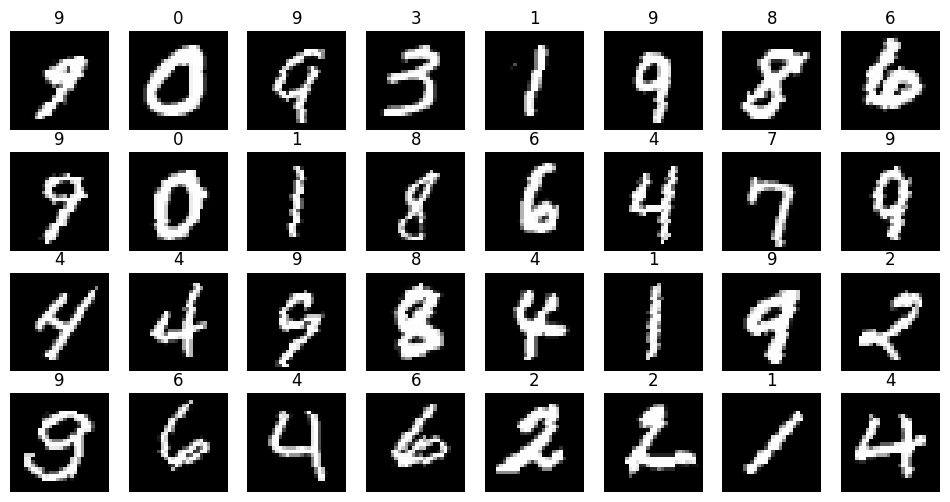

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(len(X)):
    plt.subplot(4, 8, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Epoch 19... (Train/Test) NLL: 0.068/0.068	Accuracy: 0.980/0.979

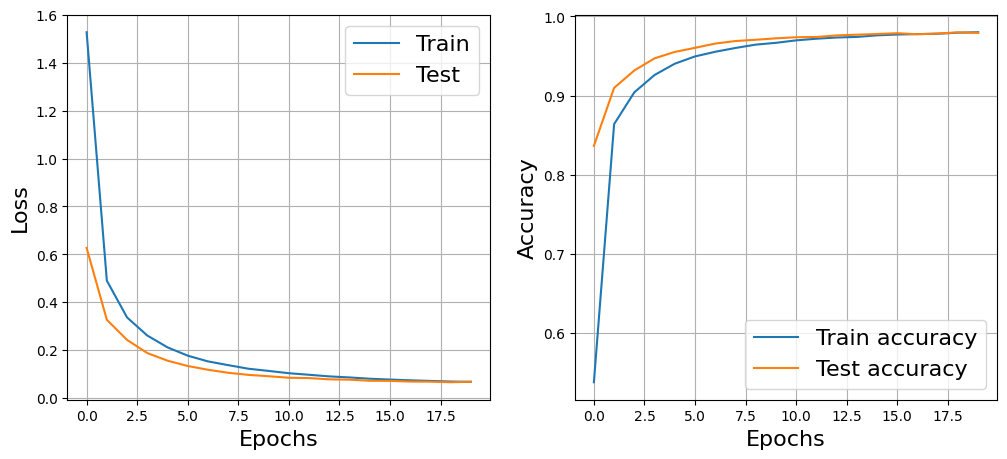

In [ ]:
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

### 2. Случайный сдвиг

In [ ]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()

In [ ]:
transform_shift = transforms.Compose([
                       transforms.RandomAffine(
                           degrees=0,
                           translate=(0.1, 0.1),
                           fill=0   ),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform_shift)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

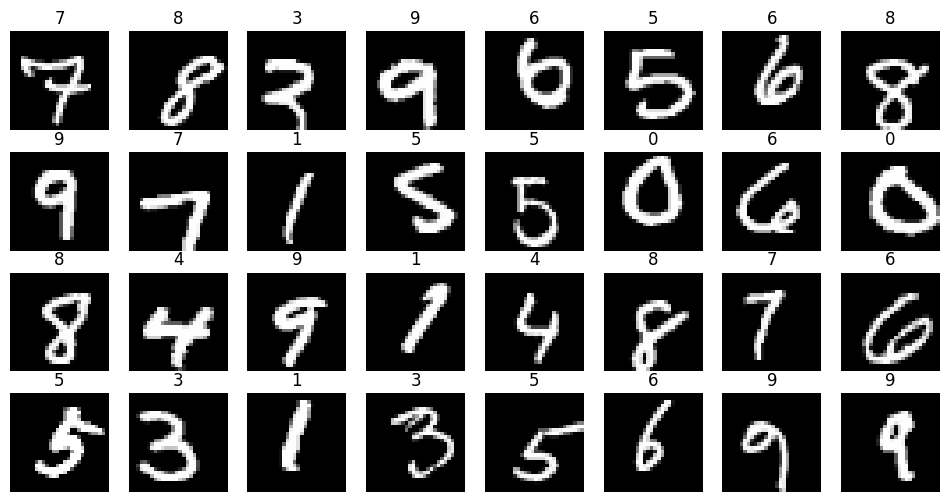

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(len(X)):
    plt.subplot(4, 8, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Epoch 19... (Train/Test) NLL: 0.119/0.079	Accuracy: 0.963/0.976

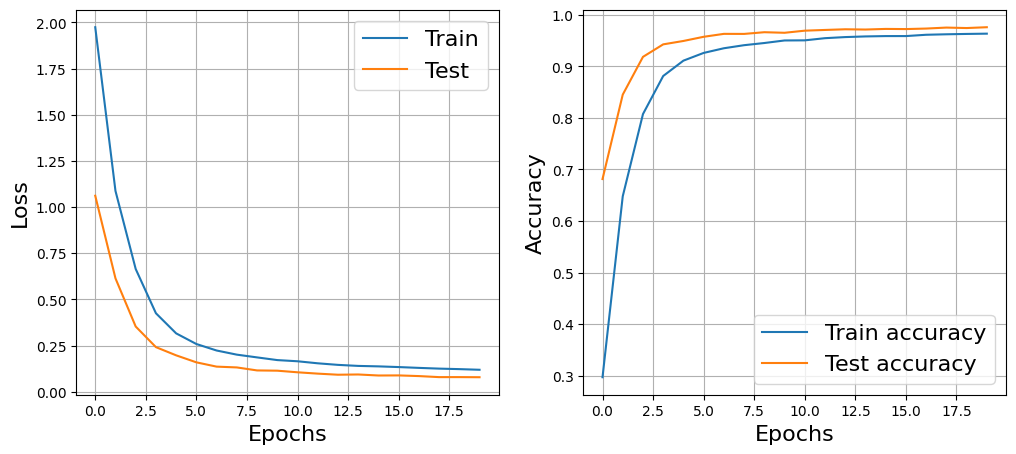

In [ ]:
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

### 3. Шум

In [ ]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()

In [ ]:
class GaussianNoise:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.zeros_like(tensor).normal_(self.mean, self.std)
        return tensor.add_(noise)

    def __repr__(self):
        repr = f"{self.__class__.__name__}(mean={self.mean},stddev={self.std})"
        return repr

In [ ]:
transform_noise = transforms.Compose([
                       transforms.ToTensor(),
                       GaussianNoise(mean=0, std=0.1),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform_noise)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

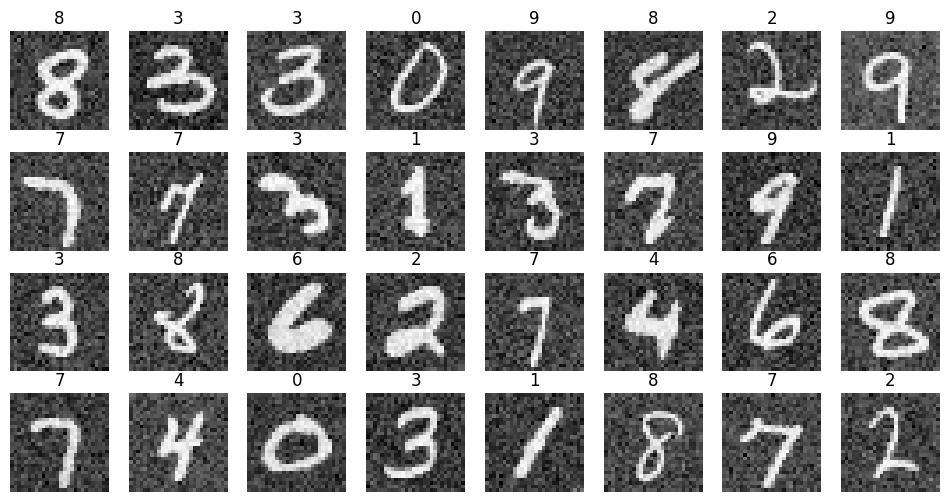

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(len(X)):
    plt.subplot(4, 8, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Epoch 19... (Train/Test) NLL: 0.041/0.078	Accuracy: 0.989/0.976

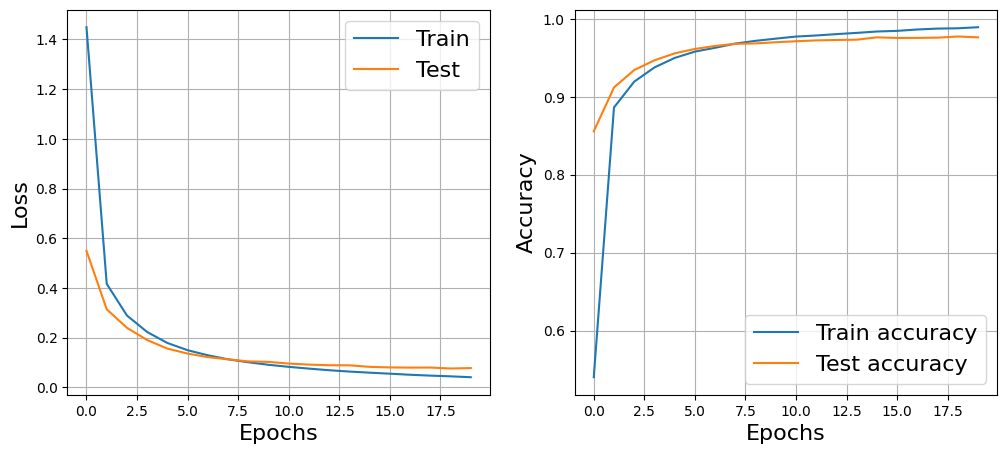

In [ ]:
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

### 4. Все аугментации вместе

In [ ]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()

In [ ]:
transform_all = transforms.Compose([
                       transforms.RandomRotation((-15, 15)), # Поворот можно осуществить и через RandomAffine
                       transforms.RandomAffine(
                           degrees=0,
                           translate=(0.1, 0.1),
                           fill=0   ),
                       transforms.ToTensor(),
                       GaussianNoise(mean=0, std=0.1),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform_all)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

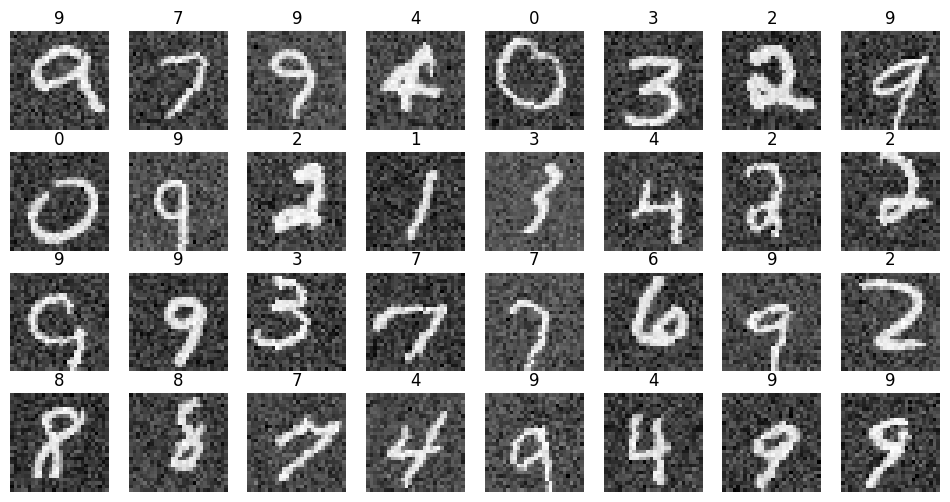

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(len(X)):
    plt.subplot(4, 8, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Epoch 19... (Train/Test) NLL: 0.148/0.066	Accuracy: 0.953/0.979

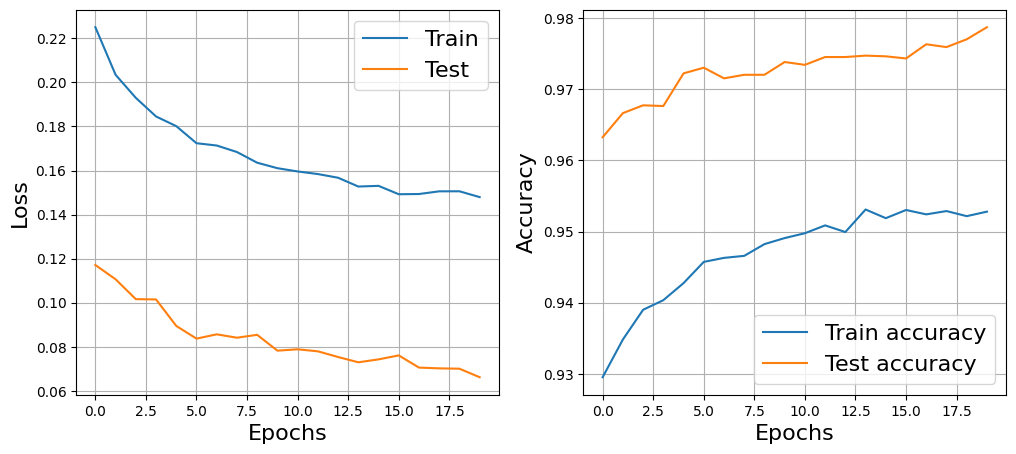

In [ ]:
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

## Выводы


*   Небольшой прирост в точности (0.3%) достигнут при небольшом случайном вращении изображений. Можно предположить, что люди пишут с различным наклоном (разная степенть наклона (сильный/слабый) и направление (вправо/влево), или наклон вообще может отсутствовать). Следовательно повышение разнообразия наклонов цифр в тренировочной выборке может привести к тому, что сеть будет лучше классифицировать объекты с большим наклоном.
*   Сдвиг изображений и добавление шума никак не повлияли на точность. Вероятно это связано с тем, что цифры в датасете хорошо отцентрованы и не содержат шум, поэтому улучшенная способность сети обрабатывать смещения и шум, не оказала влияние на точность
*   Объединение всех аугментаций увеличило точность на (0.3%), что скорее всего достигнуто за счет случайного поворота изображений.
*   Если посмотреть на анализ ошибок, то можно увидеть, что в основной массе неверно угаданные цифры либо содержат дополнительные элементы, которых не должно быть (крючки, палочки, точки), либо не содеражат нужные элементы (незамкнутый контур у нуля, шестерки, восьмерки, девятки, отсутстивие крючков и палочек), либо сама форма цифры или отдельных ее частей слишком нестандартная. Сделанные аугментации не помогают приблизить объекты тренировочной выборки к подобным нестандартным объектам тестовой, поэтому увеличение точности практически не наблюдатеся. В анализе ошибок также можно увидеть несколько аномальных картинок, на которых цифра слишком сильно наклонена, например, находится почти в горизонтальном положении. Вероятно случайный поворот обеспечил лучшую классификацию именно этих объектов.